# Forecasting Lunch and Learn Overview
    

## Setup

**Load Packages** 

In [3]:
import os 
currentwd = os.getcwd()
os.chdir('C:\\Users\\brian.trost\\Documents')
currentwd = os.getcwd()

import pandas as pd
import numpy as np

import math
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

#ARMA & VAR
import pyflux as pf

#SARIMA
import statsmodels.api as sm

#Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#RF
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

#LSTM/NN
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#TBATS
from tbats import TBATS, BATS

print('Packages are loaded, lets go')

Importing plotly failed. Interactive plots will not work.
Using TensorFlow backend.


Packages are loaded, lets go


**MAPE Function**

In [4]:
def calc_mape(df):
    df['yl'] = np.expm1(df.y)
    df['yhatl'] = np.expm1(df.yhat)
    df['mape'] = abs((df.yl-df.yhatl)/df.yl)
    df['mape'] = np.where(np.isfinite(df['mape'])==False, np.nan, df.mape)
    print('MAPE =',(df.mape.sum()*100)/len(df))

**Load Data and Plot**

In [5]:
#custom season length in the data 
seasonlength = 147

**Dataframe Dictionary**

*Date* - Visit Date

*FiscDayOfSeason* - Counts day of season based on fiscal calendar (i.e. 3rd sunday in February is always the same count)

*Season* - Visit Season

*y* - ln(Visits)+1

*bd* - Snow Base Depth (in)

*snow72* - 72 hour snowfall (in)

*acres* - # of acres open

*alt* - Median $ paid for an Advanced Lift Ticket on this day

*window* - Median $ paid for a Window Lift Ticket on this day

In [106]:
df = pd.read_csv('vail_localcore_visits.csv')

#change to datetime types
df['Date'] = pd.to_datetime(df['Date'])
df['ds'] = pd.to_datetime(df['ds'])

#observations with NA's can cause headaches for some forecasting methods - for this example we'll just remove them, they are days the resort is closed
#but methods like prophet can handle. Can also interpolate if desired
df = df[df['y'].isnull() == False]

#create train/test dataframes
df_train = df[df['Season']!='2018/19']
df_test = df[df['Season']=='2018/19']
df_test.head()

,Date,FiscDayOfSeason,Season,y,bd,snow72,acres,alt,window,ds
5,2018-11-25,22,2018/19,8.362642,35.000019,15,1621,159.0,167,2012-01-08
11,2018-11-26,23,2018/19,6.937314,32.000017,12,1621,135.0,167,2012-01-09
17,2018-11-27,24,2018/19,6.824374,31.000017,9,1621,135.0,167,2012-01-10
23,2018-11-28,25,2018/19,6.530878,29.000016,0,1621,142.0,167,2012-01-11
29,2018-11-29,26,2018/19,7.173192,33.000018,4,3532,135.0,167,2012-01-12


Our data is naturally seasonal and goes many months without observations. To combat this, I've made custom "year" lengths (147 days for Vail) and started a rolling timeseries from the first Sunday in 2010, which removes many of the leading and trailing missing values for each season. Each true 'Date' maps to a corresponding 'ds' date,

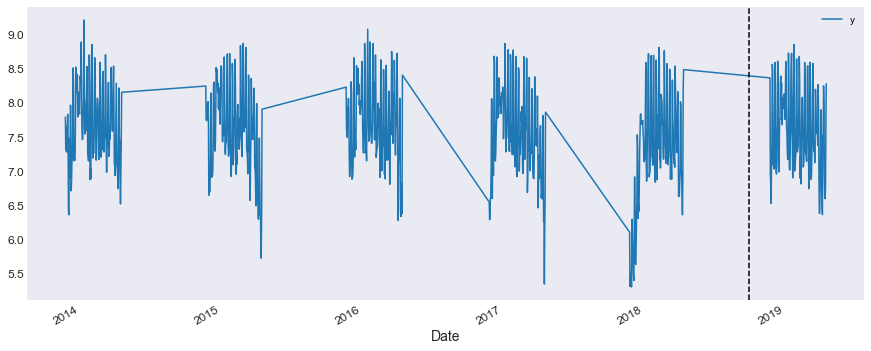

In [107]:
df_plot = df.loc[:,['y', 'Date']]
df_plot = df_plot.set_index('Date')

df_plot.plot(figsize = (15,6))
plt.axvline(x='2018-10-01', c = 'black', ls = '--')
plt.show()

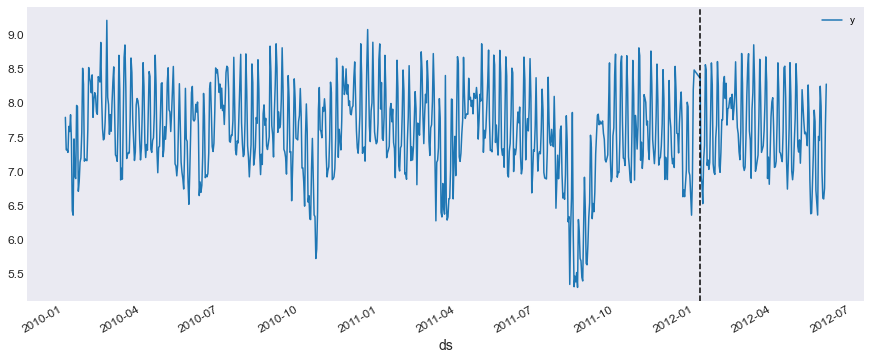

In [108]:
df_plot = df.loc[:,['y', 'ds']]
df_plot = df_plot.set_index('ds')

df_plot.plot(figsize = (15,6))
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.show()

#making a truncated version of the data for plotting visability later
df_plot2 = df_plot[df_plot.index>='2011-01-01']

## Forecasting

**Naive**

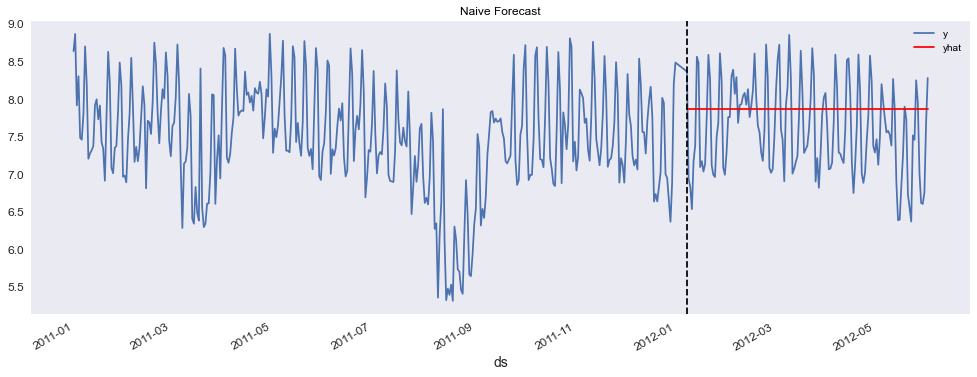

In [220]:
#naive forecasting method - take last seen observation from training data 
train_naive = df_train.loc[:,['y','Date','ds']]
train_naive = train_naive.set_index('ds')
last = train_naive.iloc[[-1]]

last_val = last['y'][0]

test_naive = df_test.loc[:, ['y','ds']]
test_naive['yhat']=last_val

#plot
test_naive_plot = test_naive.loc[:,['ds','yhat']]
test_naive_plot = test_naive_plot.set_index('ds')

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
test_naive_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('Naive Forecast')
plt.show()

In [218]:
calc_mape(test_naive)

MAPE = 75.36789485285794


**ARIMA**

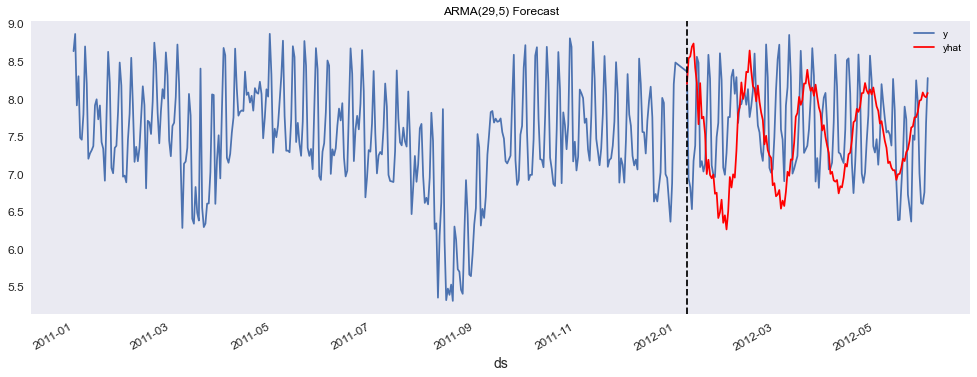

In [386]:
train_arma = df_train.loc[:,['y','ds']]
train_arma = train_arma.set_index('ds')

# ARMA(3,1)
# Data is fairly stationary upon visual inspection so lets set d=0.
# Ideally you test this assumption but this is for example only
arma = pf.ARIMA(data=train_arma, ar=29, ma=5, target = 'y', family = pf.Normal())

#fit using Maximum likelihood estimator
arma_fit = arma.fit("MLE")

#forecast out length of season
arma_predict = arma.predict(seasonlength)
arma_predict.columns = ['yhat']
arma_predict = pd.DataFrame.reset_index(arma_predict)
arma_predict = arma_predict.loc[:,['yhat']]

#concat predictions to the OOS test data
test_arma = df_test.loc[:,['y','ds']]
test_arma = pd.concat([test_arma.reset_index(drop = True), arma_predict], axis = 1)

#plot
test_arma_plot = test_arma.loc[:,['ds','yhat']]
test_arma_plot = test_arma_plot.set_index('ds')

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
test_arma_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('ARMA(29,5) Forecast')
plt.show()

In [387]:
calc_mape(test_arma)

MAPE = 79.4089875520942


*Grid Searching for optimal ARMA parameters*

In [384]:
#empty results dataframe
gridsearch = pd.DataFrame()

#ARMA Model Pipeline
for p in range(0,30):
    for q in range(0,7):
        try:
            mod = pf.ARIMA(data=train_arma, ar=p, ma=q, target = 'y', family = pf.Normal())
            results = mod.fit('MLE')
            score = pd.DataFrame([[p,q,results.aic]])
            gridsearch = gridsearch.append(score, ignore_index=True)
        except:
            continue               

In [385]:
gridsearch.columns = ['p','q','aic']
gridsearch = gridsearch.sort_values(by='aic')

#give me the winner
gridsearch.head(n=1)

,p,q,aic
208,29,5,525.81783


**ARIMAX**

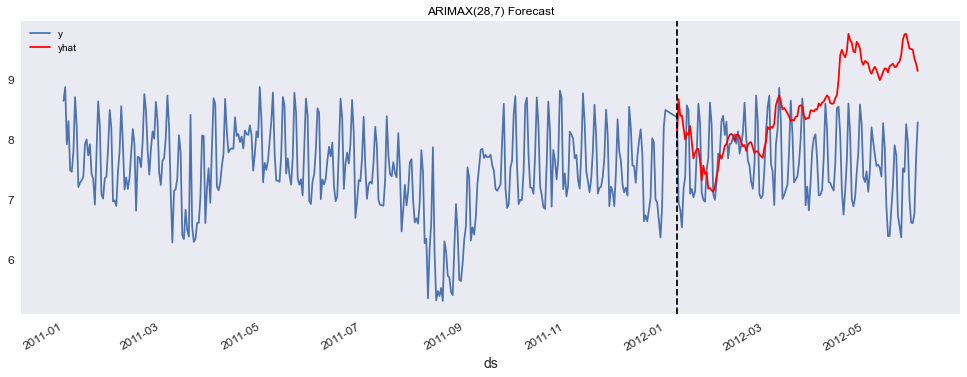

In [306]:
train_arimax = df_train
train_arimax = train_arimax.set_index('ds')

model = pf.ARIMAX(data = train_arimax, formula = 'y~1+snow72+bd+acres+alt+window', ar = 28, ma =7, family =pf.Normal())
x=model.fit("MLE")

#turn test df into OOS dataframe needed for predictions
#must have predicted values for regressors -
## here I'm using actuals + imputed values but in practice you would use weather forecasts or historical averages
oos = df_test
oos.index = oos['ds']
oos2 = oos.loc[:,['y','snow72', 'bd', 'acres', 'alt', 'window']]
oos2 = pd.DataFrame.sort_index(oos2)

#predict and reshape into the final dataframe 
arimax_pred = model.predict(seasonlength, oos2)
arimax_pred.columns = ['yhat']
arimax_pred = pd.DataFrame.reset_index(arimax_pred)
arimax_pred = arimax_pred.loc[:,['yhat']]

#concat predictions to the OOS test data
test_arimax = df_test.loc[:,['y','ds']]
test_arimax = pd.concat([test_arimax.reset_index(drop = True), arimax_pred], axis = 1)

#plot
test_arimax_plot = test_arimax.loc[:,['ds','yhat']]
test_arimax_plot = test_arimax_plot.set_index('ds')

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
test_arimax_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('ARIMAX(28,7) Forecast')
plt.show()

In [307]:
calc_mape(test_arimax)

MAPE = 309.0583842883533


**S-NAIVE**

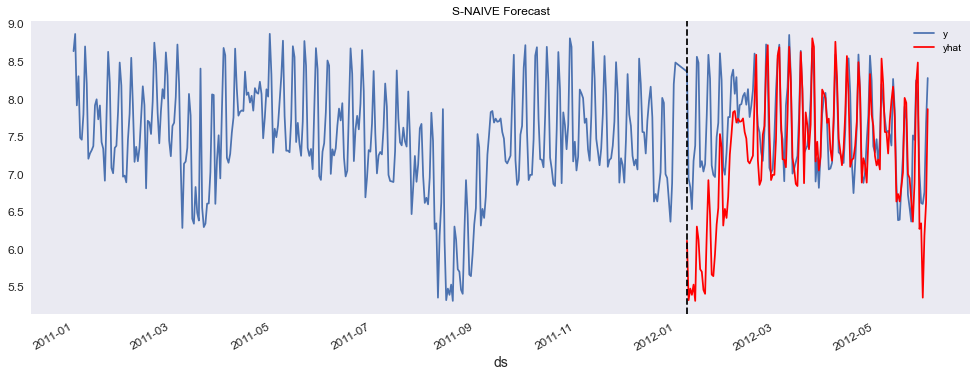

In [366]:
#Doing the seasonal naive just by taking the equivalent fiscal day visitation from LY
#some of the days are missing, so we go to the previous year obs for those.
train_snaive1 = df_train[df_train['Season']=='2017/18']
train_snaive1 = train_snaive1.loc[:,['y','FiscDayOfSeason']]
train_snaive1.columns = ['y_ly', 'FiscDayOfSeason']

train_snaive2 = df_train[df_train['Season']=='2016/17']
train_snaive2 = train_snaive2.loc[:,['y','FiscDayOfSeason']]
train_snaive2.columns = ['y_lyly', 'FiscDayOfSeason']

train_snaive = train_snaive2.merge(train_snaive1, on = 'FiscDayOfSeason', how = 'left')
train_snaive['yhat'] = np.where(train_snaive.y_ly.isna()==True, train_snaive.y_lyly, train_snaive.y_ly)
train_snaive = train_snaive.loc[:,['yhat','FiscDayOfSeason']]

#merge with test
test_snaive = df_test.loc[:,['y','ds','FiscDayOfSeason']]
test_snaive = test_snaive.merge(train_snaive, on = 'FiscDayOfSeason', how = 'left')

#plot
test_snaive_plot = test_snaive.loc[:,['ds', 'yhat']]
test_snaive_plot = test_snaive_plot.set_index('ds')

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
test_snaive_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('S-NAIVE Forecast')
plt.show()

In [370]:
calc_mape(test_snaive)

MAPE = 36.824565539530795


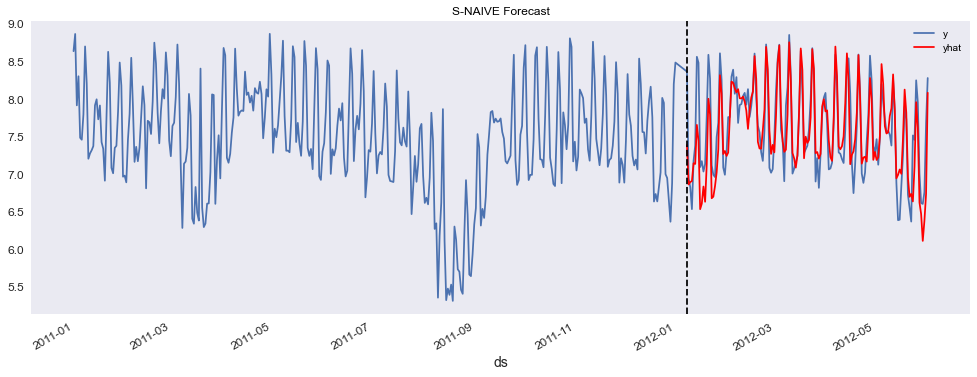

In [358]:
#Actually that's not bad after it gets over the hump of the previous year slow start (could have been bad snow)
#what if i took the average of that fiscal day 
train_snaive = df_train
train_snaive = train_snaive.groupby(['FiscDayOfSeason'], as_index=False).agg({'y':'mean'})
train_snaive.columns = ['FiscDayOfSeason', 'yhat']

#merge with test
test_snaive = df_test.loc[:,['y','ds','FiscDayOfSeason']]
test_snaive = test_snaive.merge(train_snaive, on = 'FiscDayOfSeason', how = 'left')

#plot
test_snaive_plot = test_snaive.loc[:,['ds', 'yhat']]
test_snaive_plot = test_snaive_plot.set_index('ds')

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
test_snaive_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('S-NAIVE Forecast - Historical Averages')
plt.show()

In [359]:
calc_mape(test_snaive)

MAPE = 23.31080242275191


**SARIMA**

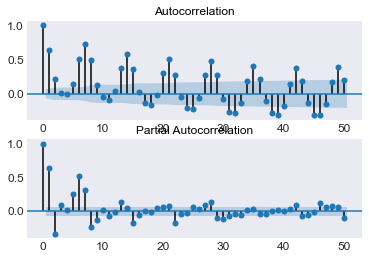

In [7]:
#plotting ACF/PACF first to see if any seasonalities pop off the page.
train_sarima = df.loc[:,['ds','y']]
train_sarima = train_sarima.sort_values(by = 'ds')
train_sarima = train_sarima.loc[:,['y']]

fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(train_sarima, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_sarima, lags=50, ax=ax[1])
plt.show()

Since we can only chose one seasonality, I think 7 is appropriate given

    a)The pacf is affected mostly in the first 7 days and 
    b)Intuitively thats one week

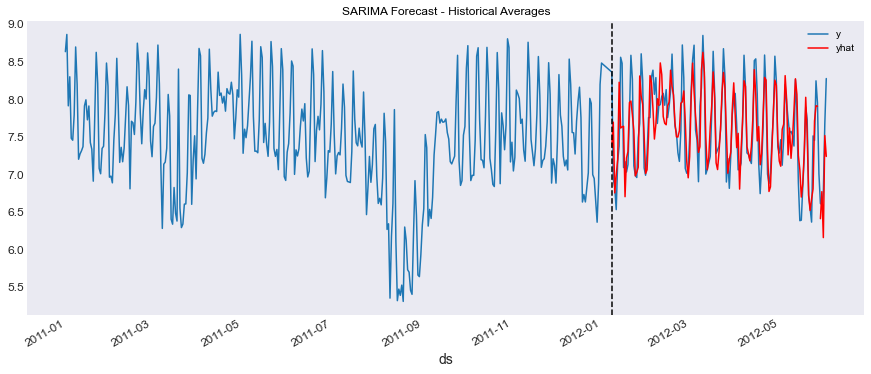

In [14]:
#SARIMA model (1,0,1)x(1,0,1)7
sarima_m = sm.tsa.statespace.SARIMAX(endog = train_sarima, 
                                             order = (6,0,6), seasonal_order = (6,0,6,7))
sarima_m = sarima_m.fit()

test_sarima = df_test.loc[:,['ds']]

pred_date_max = test_sarima.ds.values.max()
pred_date_min = test_sarima.ds.values.min()
                                                                                              
sarimax_pred = pd.DataFrame(sarima_m.predict())
#sarimax_pred = fit.forecast(rc)

sarimax_pred.columns = ['yhat']

sarimax_predictions = pd.concat([df.reset_index(drop = True), sarimax_pred], axis = 1)
sarimax_predictions = sarimax_predictions[sarimax_predictions['Season']=='2018/19']


#plot
sarimax_test_plot = sarimax_predictions.loc[:,['ds','yhat']]
sarimax_test_plot = sarimax_test_plot.set_index('ds')


ax = df_plot2.plot(label = 'observed', figsize = (15,6))
sarimax_test_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('SARIMA Forecast - Historical Averages')
plt.show()

In [13]:
calc_mape(sarimax_predictions)

MAPE = 28.14368803547497


*Going to do the same grid searching to see optimal parameters in a 7 day seasonality model - not going to bother optimizing d/D since the data is fairly stationary without differencing*

In [10]:
#empty results dataframe
gridsearch = pd.DataFrame()

#SARIMA Model Pipline 
for p in range(0,8):
    for q in range(0,8):
        try:
            mod = sm.tsa.statespace.SARIMAX(endog = train_sarima, 
                                     order = (p,0,q), seasonal_order = (p,0,q,7))
            res = mod.fit()
            score = pd.DataFrame([[p,q,res.aic]])
            gridsearch = gridsearch.append(score, ignore_index=True)
        except:
            continue 

In [11]:
gridsearch.columns = ['p','q','aic']
gridsearch = gridsearch.sort_values(by='aic')

#give me the winner
gridsearch.head(n=1)

,p,q,aic
47,6,6,553.815208


**TBATS** (try to only run first cell once - computationally intensive)

In [547]:
tbats_train = df_train.loc[:,['ds', 'y']]
tbats_train = tbats_train.set_index('ds')

#fit the model - three seasonalities
estimator = BATS(seasonal_periods=[3,7])
model = estimator.fit(tbats_train)

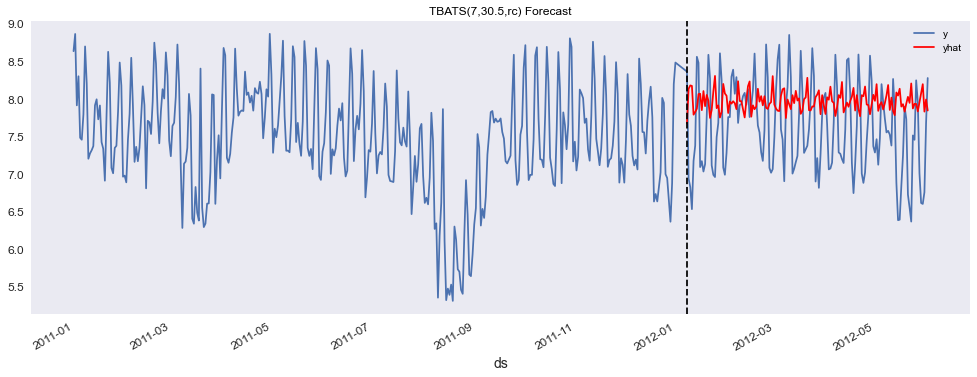

In [548]:
tbats_pred = pd.DataFrame(model.forecast(steps = seasonlength))
tbats_pred.columns = ['yhat']

test_tbats = df_test.loc[:,['y','ds']]
test_tbats = pd.concat([test_tbats.reset_index(drop = True), tbats_pred], axis = 1)

#plot
test_tbats_plot = test_tbats.loc[:,['ds', 'yhat']]
test_tbats_plot = test_tbats_plot.set_index('ds')

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
test_tbats_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('TBATS(7,30.5,rc) Forecast')
plt.show()

In [549]:
calc_mape(test_tbats)

MAPE = 99.69235138381406


**FBProphet**

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


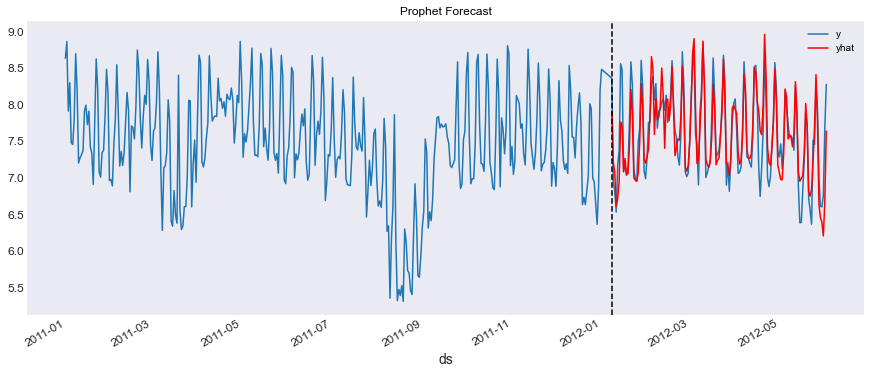

In [22]:
#set up our training/test data and model
train_prophet = df_train.loc[:,['ds','y','bd','snow72','acres','window','alt']]
test_prophet = df_test.loc[:,['ds','y','bd','snow72','acres','window','alt']]

#load in our holiday file - pre-altered for the altered ds index
holidays = pd.read_csv('holidays.csv')

#turn off the built in seasonalities in favor of our own. Easier to play around with the parameters
m = Prophet(weekly_seasonality = False, yearly_seasonality = False,
           changepoint_prior_scale = 0.01, holidays = holidays,
           holidays_prior_scale = 10, seasonality_prior_scale = 20)

m.add_seasonality(name = 'ski season', period = seasonlength, fourier_order = 20, mode = 'multiplicative')
m.add_seasonality(name = 'week', period =7, fourier_order = 20, mode = 'multiplicative')

#add the weather/ticket price regressors
m.add_regressor('snow72', mode = 'multiplicative')
m.add_regressor('bd', mode = 'multiplicative')
m.add_regressor('acres', mode = 'multiplicative')
m.add_regressor('alt', mode = 'multiplicative')
m.add_regressor('window', mode = 'multiplicative')

m.fit(train_prophet)

#create future data frame, join it to test_prophet to get the regressors
#future = m.make_future_dataframe(periods=rc, include_history = False)
#future = future.merge(test_prophet, on = 'ds', how = 'left')

forecast = m.predict(test_prophet)

forecast1 = forecast.loc[:,['ds','yhat']]

tp = test_prophet.loc[:,['ds', 'y']]

forecast1 = forecast1.merge(tp, on = 'ds', how = 'left')

#plot
test_prophet_plot = forecast1.loc[:,['ds', 'yhat']]
test_prophet_plot = test_prophet_plot.set_index('ds')

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
test_prophet_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('Prophet Forecast')
plt.show()

In [23]:
calc_mape(forecast1)

MAPE = 21.506706612057723


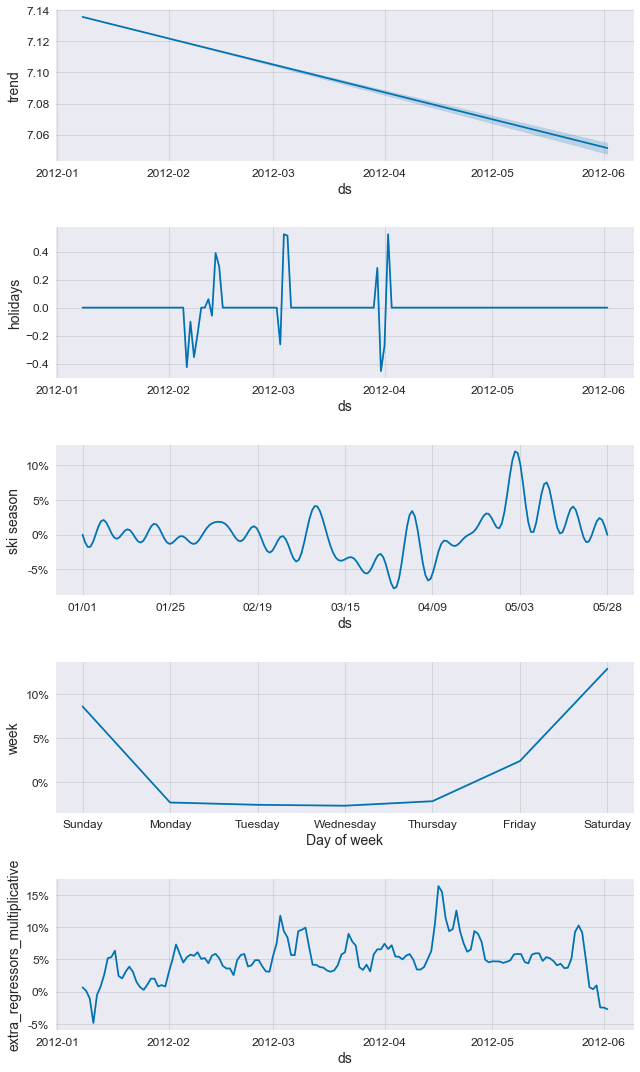

In [487]:
fig = m.plot_components(forecast)

**Neural Nets (Long Term Short Memory)**

In [239]:
#set up - need to normalize data for LSTM (sensitive to scale of data0)
scaler = MinMaxScaler(feature_range = (0,1))

#train
train_lstm = df_train.loc[:,['ds','y']]
train_lstm = df_train.set_index('ds')

train_lstm_v = train_lstm['y'].values
train_lstm_v = train_lstm_v.reshape(-1,1)
train_lstm_s = scaler.fit_transform(train_lstm_v)

In [240]:
#make scalable function that will create dataset
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a=dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX), np.array(dataY)

In [249]:
look_back = seasonlength

#test set manip
test_lstm = df.loc[:,['ds','y']]
test_lstm = test_lstm.set_index('ds').sort_index()
test_lstm = test_lstm.reset_index()

test_lstm_subset = test_lstm.loc[(len(df_train)-look_back-1):]
test_lstm_v = test_lstm_subset['y'].values
test_lstm_v = test_lstm_v.reshape(-1,1)
test_lstm_s = scaler.fit_transform(test_lstm_v)

trainX, trainY = create_dataset(train_lstm_s, look_back)
testX, testY = create_dataset(test_lstm_s, look_back)

#LSTM needs a specific structure to work
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1, testX.shape[1]))

In [270]:
#create and fit the LSTM network

model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences = True, input_shape =(1,look_back)))
model.add(LSTM(100, activation = 'relu', return_sequences=True))
model.add(LSTM(100, activation = 'relu', return_sequences=True))
model.add(LSTM(100, activation = 'relu', return_sequences=True))
model.add(LSTM(100, activation = 'relu', return_sequences=True))
model.add(LSTM(100, activation = 'relu', return_sequences=True))
model.add(LSTM(100, activation = 'relu', return_sequences=True))
model.add(LSTM(100, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = 1000, batch_size=1, verbose=1)

Epoch 1/1000
581/581 [==============================] - 5s 8ms/step - loss: 0.0518
Epoch 2/1000
581/581 [==============================] - 3s 5ms/step - loss: 0.0196
Epoch 3/1000
581/581 [==============================] - 3s 5ms/step - loss: 0.0167
Epoch 4/1000
581/581 [==============================] - 3s 5ms/step - loss: 0.0129
Epoch 5/1000
581/581 [==============================] - 3s 5ms/step - loss: 0.0126
Epoch 6/1000
581/581 [==============================] - 3s 5ms/step - loss: 0.0114
Epoch 7/1000
581/581 [==============================] - 3s 5ms/step - loss: 0.0116
Epoch 8/1000
581/581 [==============================] - 3s 5ms/step - loss: 0.0111
Epoch 9/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0099
Epoch 10/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0104
Epoch 11/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0097
Epoch 12/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0088
E

581/581 [==============================] - 3s 6ms/step - loss: 0.0027
Epoch 195/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0029
Epoch 196/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0028
Epoch 197/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0027
Epoch 198/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0028
Epoch 199/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0026
Epoch 200/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0027
Epoch 201/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0025
Epoch 202/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0024
Epoch 203/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0030
Epoch 204/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0025
Epoch 205/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.

581/581 [==============================] - 3s 6ms/step - loss: 9.3802e-04
Epoch 386/1000
581/581 [==============================] - 3s 5ms/step - loss: 6.3711e-04
Epoch 387/1000
581/581 [==============================] - 3s 5ms/step - loss: 8.4263e-04
Epoch 388/1000
581/581 [==============================] - 3s 5ms/step - loss: 0.0011
Epoch 389/1000
581/581 [==============================] - 3s 5ms/step - loss: 6.6580e-04
Epoch 390/1000
581/581 [==============================] - 3s 5ms/step - loss: 7.5228e-04
Epoch 391/1000
581/581 [==============================] - 3s 5ms/step - loss: 7.2828e-04
Epoch 392/1000
581/581 [==============================] - 3s 6ms/step - loss: 7.8756e-04
Epoch 393/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0023
Epoch 394/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0085
Epoch 395/1000
581/581 [==============================] - 3s 5ms/step - loss: 0.0065
Epoch 396/1000
581/581 [============================

581/581 [==============================] - 3s 6ms/step - loss: 0.0016
Epoch 571/1000
581/581 [==============================] - 3s 6ms/step - loss: 2.7777e-04
Epoch 572/1000
581/581 [==============================] - 3s 6ms/step - loss: 1.9633e-04
Epoch 573/1000
581/581 [==============================] - 3s 6ms/step - loss: 2.2974e-04
Epoch 574/1000
581/581 [==============================] - 3s 6ms/step - loss: 6.0464e-04
Epoch 575/1000
581/581 [==============================] - 3s 6ms/step - loss: 2.7288e-04
Epoch 576/1000
581/581 [==============================] - 3s 6ms/step - loss: 1.9015e-04
Epoch 577/1000
581/581 [==============================] - 3s 6ms/step - loss: 6.7253e-04
Epoch 578/1000
581/581 [==============================] - 3s 6ms/step - loss: 3.6538e-04
Epoch 579/1000
581/581 [==============================] - 3s 6ms/step - loss: 3.8061e-04
Epoch 580/1000
581/581 [==============================] - 3s 6ms/step - loss: 5.7008e-04
Epoch 581/1000
581/581 [================

581/581 [==============================] - 3s 6ms/step - loss: 1.5757e-04
Epoch 663/1000
581/581 [==============================] - 3s 6ms/step - loss: 8.5189e-04
Epoch 664/1000
581/581 [==============================] - 3s 6ms/step - loss: 2.2525e-04
Epoch 665/1000
581/581 [==============================] - 3s 6ms/step - loss: 1.0447e-04
Epoch 666/1000
581/581 [==============================] - 3s 6ms/step - loss: 1.7406e-04
Epoch 667/1000
581/581 [==============================] - 3s 6ms/step - loss: 3.0943e-04
Epoch 668/1000
581/581 [==============================] - 3s 6ms/step - loss: 7.4288e-04
Epoch 669/1000
581/581 [==============================] - 3s 6ms/step - loss: 2.2522e-04
Epoch 670/1000
581/581 [==============================] - 3s 6ms/step - loss: 3.9369e-04
Epoch 671/1000
581/581 [==============================] - 3s 6ms/step - loss: 1.4170e-04
Epoch 672/1000
581/581 [==============================] - 3s 6ms/step - loss: 3.1878e-04
Epoch 673/1000
581/581 [============

581/581 [==============================] - 3s 6ms/step - loss: 1.1313e-04
Epoch 847/1000
581/581 [==============================] - 3s 6ms/step - loss: 4.7424e-04
Epoch 848/1000
581/581 [==============================] - 3s 6ms/step - loss: 0.0040
Epoch 849/1000
581/581 [==============================] - 3s 6ms/step - loss: 6.9120e-04
Epoch 850/1000
581/581 [==============================] - 3s 6ms/step - loss: 2.2646e-04
Epoch 851/1000
581/581 [==============================] - 3s 6ms/step - loss: 1.3955e-04
Epoch 852/1000
581/581 [==============================] - 3s 6ms/step - loss: 7.6178e-05
Epoch 853/1000
581/581 [==============================] - 3s 6ms/step - loss: 1.7751e-04
Epoch 854/1000
581/581 [==============================] - 3s 6ms/step - loss: 1.1023e-04
Epoch 855/1000
581/581 [==============================] - 3s 6ms/step - loss: 1.1152e-04
Epoch 856/1000
581/581 [==============================] - 3s 6ms/step - loss: 7.6444e-04
Epoch 857/1000
581/581 [================

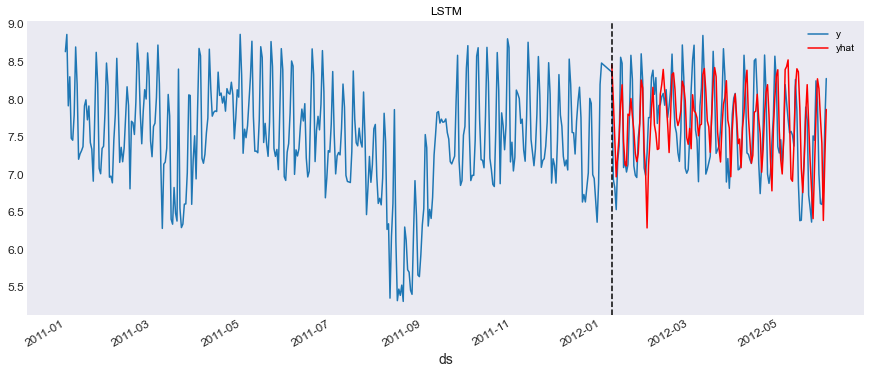

In [271]:
#make predictions 
predict = model.predict(testX)
#invert predictions
pred = scaler.inverse_transform(predict)
predict = pd.DataFrame(scaler.inverse_transform(predict))
predict.columns = ['yhat']
testY = testY.reshape(-1,1)
orig = pd.DataFrame(scaler.inverse_transform(testY))
orig.columns = ['y']

predict = pd.concat([predict.reset_index(drop=True), orig], axis =1)

#plot
lstmp1 = df_test.loc[:,['ds']]
lstmp1 = lstmp1.set_index('ds').sort_index()
predict = predict.set_index(lstmp1.index)
lstmp_plot = predict.loc[:,['yhat']]

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
lstmp_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('LSTM')
plt.show()

In [272]:
calc_mape(predict)

MAPE = 39.30582800420842


In [529]:
# to be able to plot, we have to shift the predictions to alighn with the original X dataset


In [22]:
len(train_lstm)

729

In [112]:
lstmp_plot.head()
lstmp_plot.dtypes

ds      datetime64[ns]
yhat           float32
dtype: object

In [95]:
len(predict)

147

In [132]:
predict.head()

,yhat,y,yl,yhatl,mape
ds,,,,,
2012-01-08,7.760516,8.483223,4832.000001,2345.114258,0.514670
2012-01-09,7.483330,8.362642,4283.000002,1777.152588,0.585068
2012-01-10,7.395314,6.937314,1029.000000,1627.335693,0.581473
2012-01-11,7.133559,6.824374,919.000000,1252.329956,0.362709
2012-01-12,7.410387,6.530878,685.000000,1652.065186,1.411774


**LSTM Try #2 - Rolling Window Training**

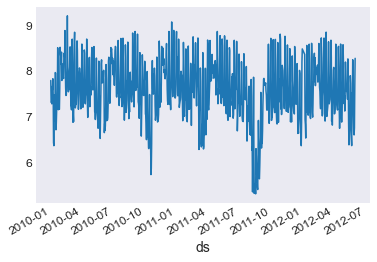

In [139]:
df.groupby(['ds']).sum()['y'].plot()

In [167]:
train = df_train.loc[:,['ds','y']].set_index('ds')
test = df_test.loc[:,['ds','y']].set_index('ds')

scaler = MinMaxScaler()
train_scale = scaler.fit_transform(train.values.reshape(-1,1)).reshape(1,-1)[0]
test_scale = scaler.fit_transform(test.values.reshape(-1,1)).reshape(1,-1)[0]

In [227]:
def split_training(timeseries, num_in, num_out):
    
    # intialize vectors for the input and output into the NN
    in_vec = []
    out_vec = []
    
    # determine how many training examples can be made
    num_instances = timeseries.shape[0] - num_in - num_out + 1
    
    # loop over the timeseries
    for i in range(num_instances):
        
        # input and output data for each instance
        data_inp = timeseries[i:num_in + i]
        data_out = timeseries[num_in + i:num_in + num_out+i]
        
        # store values
        in_vec.append(data_inp)
        out_vec.append(data_out)
        
    return np.array(in_vec),np.array(out_vec)

num_out = 7
num_in = 50

X,y = split_training(train_scale, num_in, num_out)

In [228]:
train = df_train.loc[:,['ds','y']].set_index('ds')

test_lstm = df.loc[:,['ds','y']]
test_lstm = test_lstm.set_index('ds').sort_index()
test_lstm = test_lstm.reset_index().loc[:,['y']]

test_lstm_subset = test_lstm.loc[(len(df_train)-num_out-num_in-5):]

scaler = MinMaxScaler()
train_scale = scaler.fit_transform(train.values.reshape(-1,1)).reshape(1,-1)[0]
test_scale = scaler.fit_transform(test_lstm_subset.values.reshape(-1,1)).reshape(1,-1)[0]

In [229]:
X,y = split_training(train_scale, num_in, num_out)

In [230]:
print('X shape:', X.shape)
print('Y shape', y.shape)

X shape: (673, 50)
Y shape (673, 7)


In [231]:
#training
features = 1

X = X.reshape((X.shape[0], X.shape[1], features))

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(num_in, features)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu'))
model.add(Dense(num_out))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, verbose=1)

Epoch 1/100
673/673 [==============================] - 3s 4ms/step - loss: 0.1939
Epoch 2/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0282
Epoch 3/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0253
Epoch 4/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0244
Epoch 5/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0261
Epoch 6/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0298
Epoch 7/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0251
Epoch 8/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0227
Epoch 9/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0371
Epoch 10/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0268
Epoch 11/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0256
Epoch 12/100
673/673 [==============================] - 2s 3ms/step - loss: 0.0255
Epoch 13/100


In [182]:
yhat = model.predict(X_test, verbose = 0)[0]

In [186]:
yhat[-1]


7.4546356

In [184]:
yhat = scaler.inverse_transform(yhat.reshape(-1,1)).reshape(1,-1)[0]


In [185]:
yhat

array([7.827201 , 7.7865524, 7.625724 , 7.6033063, 7.5334935, 7.4804726,
       7.4546356], dtype=float32)

In [232]:
#Prediction
num_out = 7
num_in = 50
X_test, y_test = split_training(test_scale,num_in,num_out)
features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], features))

In [236]:
#predict daily forecast for each week and take last value for forecast
actuals = []
predictions = []

for i,y_actual in enumerate(y_test):
    x_input = X_test[i].T[0]
    x = x_input
    x_input = x_input.reshape((1, num_in, features))
    yhat = model.predict(x_input, verbose=0)[0]
    yhat = scaler.inverse_transform(yhat.reshape(-1,1)).reshape(1,-1)[0]
    y_actual = scaler.inverse_transform(y_actual.reshape(-1,1)).reshape(1,-1)[0]
    actuals.append(y_actual[0])
    predictions.append(yhat[0])
actuals = np.array(actuals)[:-6]
predictions = np.array(predictions)[:-6]
residuals = actuals - predictions
percent_error = abs(residuals) / actuals * 100

In [237]:
print(np.mean(percent_error))

7.364274651470733


In [203]:
len(predictions)

147

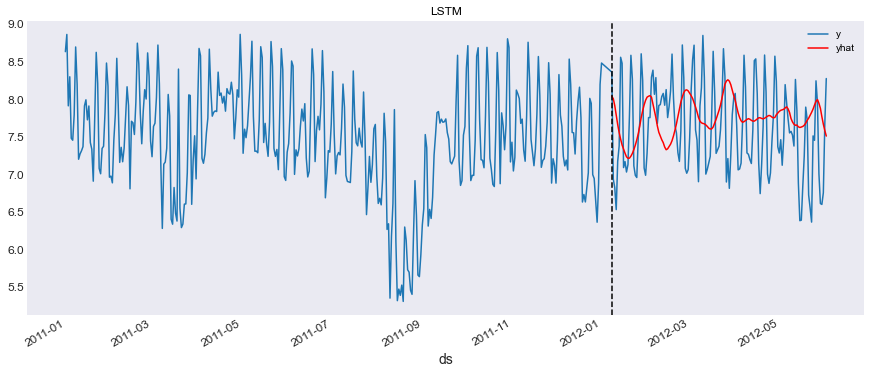

In [238]:
lstm_test = df_test.loc[:,['ds','y']].set_index('ds').sort_index()
pred = pd.DataFrame(predictions)
pred.columns = ['yhat']

lstm_test_pred = pd.concat([lstm_test.reset_index(drop = True), pred], axis = 1)

lstm_test_plot = pred.set_index(lstm_test.index)

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
lstm_test_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('LSTM')
plt.show()

In [212]:
calc_mape(lstm_test_pred)

MAPE = 63.579208258459005


**Vector Auto Regression (VAR)**

In [416]:
#need to load in our last file - the file that has the 4 time series for VAR 

df_var = pd.read_csv('VAR_timeseries_sample.csv')
df_var.head()

df_var_plot = df_var
df_var_plot['ds'] = pd.to_datetime(df_var['ds'])
df_var_plot = df_var_plot.set_index('ds')

df_var['bc_visits'] = np.where(df_var['bc_visits'].isnull() == True, 0, df_var['bc_visits'])
df_var['y'] = np.where(df_var['y'].isnull() == True, 0, df_var['y'])
df_var['breck_vists'] = np.where(df_var['breck_vists'].isnull() == True, 0, df_var['breck_vists'])
df_var['keystone_visits'] = np.where(df_var['keystone_visits'].isnull() == True, 0, df_var['keystone_visits'])

df_var['ds'] = pd.to_datetime(df_var['ds'])

df_var = df_var.groupby(['ds']).agg({'y':'max', 'bc_visits':'max', 'breck_vists':'max', 'keystone_visits':'max'})

#df_var = df_var.set_index('ds').sort_index().drop(columns = ['Date'])

df_var_train = df_var[df_var.index < '2012-01-08']
df_var_test = df_var[df_var.index >= '2012-01-08']

In [417]:
model = pf.VAR(data = df_var_train, lags = 7, integ = 0, target = 'y')

x = model.fit()

var_predict = model.predict(147)

var_predict_vail = var_predict.loc[:,['y']]
var_predict_vail.columns = ['yhat']
var_predict_bc = var_predict.loc[:,['bc_visits']]
var_predict_bc.columns = ['yhat']
var_predict_breck = var_predict.loc[:,['breck_vists']]
var_predict_breck.columns = ['yhat']
var_predict_key = var_predict.loc[:,['keystone_visits']]
var_predict_key.columns = ['yhat']

var_actuals_vail = df_var_test.loc[:,['y']]
var_actuals_vail.columns = ['y']
var_actuals_bc = df_var_test.loc[:,['bc_visits']]
var_actuals_bc.columns = ['y']
var_actuals_breck = df_var_test.loc[:,['breck_vists']]
var_actuals_breck.columns = ['y']
var_actuals_key = df_var_test.loc[:,['keystone_visits']]
var_actuals_key.columns = ['y']

In [418]:
var_predict_vail = var_predict_vail.merge(var_actuals_vail, 
                                          left_index = True,
                                         right_index=True)

var_predict_bc = var_predict_bc.merge(var_actuals_bc, 
                                          left_index = True,
                                         right_index=True)

var_predict_breck = var_predict_breck.merge(var_actuals_breck, 
                                          left_index = True,
                                         right_index=True)

var_predict_key = var_predict_key.merge(var_actuals_key, 
                                        left_index = True,
                                         right_index=True)

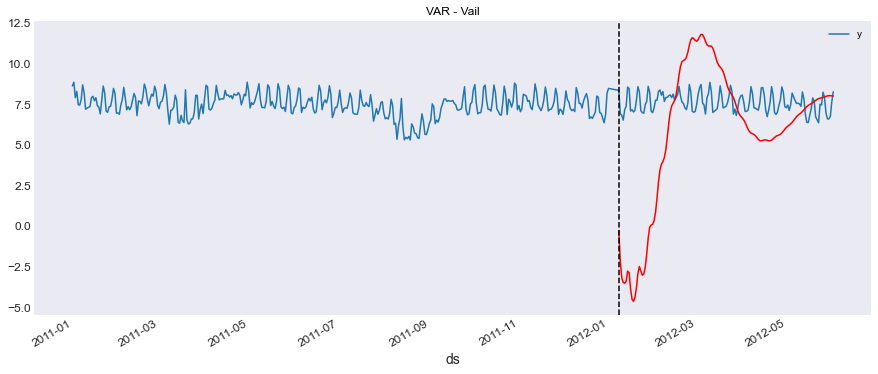

In [430]:
#plot vail
var_vail_plot = var_predict_vail.loc[:,'yhat']

ax = df_plot2.plot(label = 'observed', figsize = (15,6))
var_vail_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('VAR - Vail')
plt.show()

In [423]:
calc_mape(var_predict_vail)

MAPE = 716.3389344305715


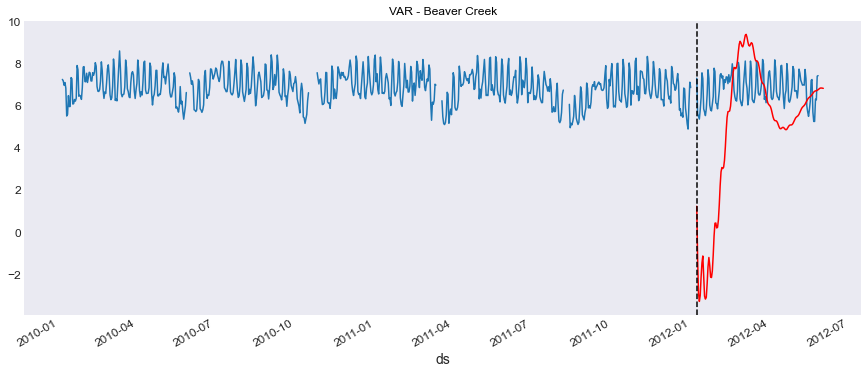

In [429]:
var_bc_plot = var_predict_bc.loc[:,'yhat']

df_plot2_bc = df_var_plot.loc[:,'bc_visits']

ax = df_plot2_bc.plot(label = 'observed', figsize = (15,6))
var_bc_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('VAR - Beaver Creek')
plt.show()

In [424]:
calc_mape(var_predict_bc)

MAPE = 197.64859196078112


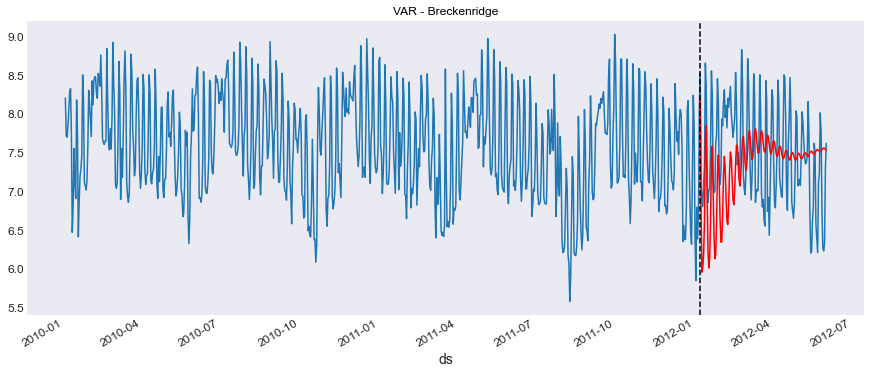

In [421]:
var_breck_plot = var_predict_breck.loc[:,'yhat']
df_plot2_br = df_var_plot.loc[:,'breck_vists']

ax = df_plot2_br.plot(label = 'observed', figsize = (15,6))
var_breck_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('VAR - Breckenridge')
plt.show()

In [425]:
calc_mape(var_predict_breck)

MAPE = 67.63066127773679


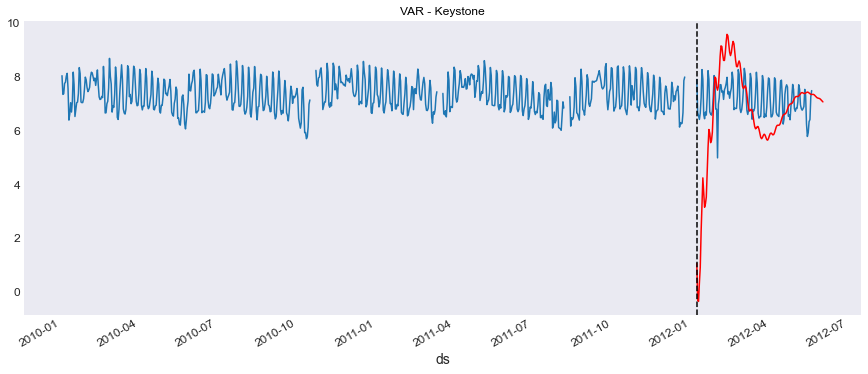

In [428]:
var_key_plot = var_predict_key.loc[:,'yhat']
df_plot2_key = df_var_plot.loc[:,'keystone_visits']

ax = df_plot2_key.plot(label = 'observed', figsize = (15,6))
var_key_plot.plot(ax=ax, label = 'Naive', c = 'red')
plt.axvline(x='2012-01-08', c = 'black', ls = '--')
plt.title('VAR - Keystone')
plt.show()

In [426]:
calc_mape(var_predict_key)

MAPE = 124.77894546721878
